In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
classes = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

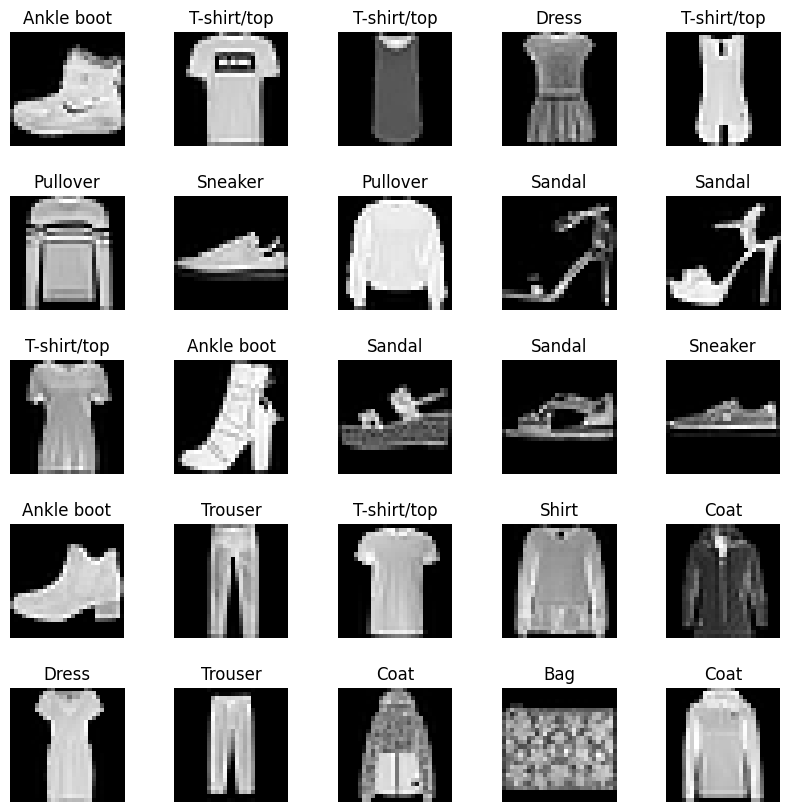

In [4]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5,5),  # creates 2x2 grid of axes`
                 axes_pad=0.5,  # pad between axes in inch.
                 )
for ax, im, text in zip(grid,x_train,y_train):
    ax.imshow(im,cmap = 'gray')
    ax.axis('off')
    ax.set_title(classes[text])
plt.show()


In [5]:
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


In [81]:
inputData = [ img.flatten().reshape(-1,1) for img in x_train ]

In [82]:
inputData[0].shape

(784, 1)

In [24]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [79]:
def backPropagation(hiddenLayers,y_train,preActivations,activations,predictedOut,inputData):
    # dW_out = np.zeros(outputLayer[0].shape,dtype=np.float64)
    # dB_out = np.zeros(outputLyaer[1].shape,dtype=np.float64)
    # dW = np.zeros(weights.shape, dtype = np.float64)
    # dB = np.zeros(biaes.shape, dtype = np.float64)
    # for i in range(len(y_train)):
    #     index = y_train[i]
    #     oneHot = np.zeros((len(outPreActivations),1),dtype = np.float64)
    #     oneHot[index] = 1
    #     gradOut = - ( oneHot - predictedOut[i] )
    #     prevHGrad = np.empty( (2,3) )
    #     prevAGrad= np.empty((2,3))
    #     for k in range(hiddenLayers-1,-1,-1):
    #         if k==hiddenLayers-1:
    #             dW_out += np.dot(gradOut,activations[k].T)
    #             dB_out += gradOut
    #             prevHGrad = np.dot(outputLayer[0].T,gradOut)
    #             prevAGrad = prevHGrad*(preActivations[k]) # number of neurons,1 in hidden layer
    #         elif k==0:
    #             # do something for input layer
    #         else:
    #             dW += np.dot(prevAGrad,activations[k].T)
    #             dB += prevAGrad
    #             prevHGrad = np.dot(weights[k])
    dW =[ 0 for i in range(hiddenLayers+1)]
    dB =[ 0 for i in range(hiddenLayers+1)]
    for i in range(len(y_train)):
        index = y_train[i]
        oneHot = np.zeros((len(preActivations[hiddenLayers]),1),dtype = np.float64)
        oneHot[index] = 1
        gradOut = -(oneHot - predictedOut[i].reshape(-1,1))
        dPH = np.empty((2,3))
        dPA = gradOut

        for k in range(hiddenLayers,0,-1):
            dW[k]+= np.dot(dPA,activations[k-1].T)
            dB[k] += dPA
            dPH = np.dot(weights[k].T,dPA)
            dPA = dPH*(sigmoid(preActivations[k-1])*(1-sigmoid(preActivations[k-1])))
        dW[0]+=np.dot(dPA,inputData[0].T)
        dB[0]+=dPA
    return dW,dB
                


In [53]:
# output[0] = weight matrix of shape outputClasses * no of neurons in hidden layers
# output[1] = bias vector of size no of classes

def feed_forward(hiddenLayers,weights, biases, preActivations, activations,inputData):
    predictedOut = np.zeros(shape = (len(inputData),10,1), dtype= np.float64)
    # for i in range(len(inputData)):

    #     for j in range(hiddenLayers):
    #         if j==0: # it means we are mapping inputs to first hidden layer
    #             preActivations[j] = biases[j] + np.dot(inputWeights,inputData[i])
    #             activations[j] = sigmoid(preActivations[j])
    #         else:
    #             preActivations[j] = biases[j] + np.dot(weights[j-1],activations[j-1]) # weights has index [j-1] b'coz we have (hiddenLayers - 1) matrices in weights
    #             activations[j] = sigmoid(preActivations[j])
    #     outPreActivation = outputLayer[1] + np.dot(outputLayer[0],activations[hiddenLayers-1])
    #     predictedOut[i] = softmax(outPreActivations)

    for i in range(len(inputData)):

        for j in range(hiddenLayers):
            if j==0:
                preActivations[j] = biases[j] + np.dot(weights[j],inputData[i].reshape(-1,1))
                activations[j] = sigmoid(preActivations[j])
            else:
                preActivations[j] = biases[j] + np.dot(weights[j],activations[j-1])
                activations[j] = sigmoid(preActivations[j])
        preActivations[hiddenLayers] = biases[hiddenLayers] + np.dot(weights[hiddenLayers],activations[hiddenLayers-1])
        predictedOut[i] = softmax(preActivations[hiddenLayers]) 
    return predictedOut
    

In [84]:
def gradientDescent(inputData,y_train,epochs,lr,hiddenLayers,neuronsHiddenLayer):
    featuresInOneInput = inputData[0].shape[0]
    outputClasses = 10
    totalSamples = len(inputData)
    weights, biases, preActivations, activations = Initialize(hiddenLayers=hiddenLayers,neuronsHiddenLayer=neuronsHiddenLayer,outputClasses=outputClasses,featuresInOneInput=784)
    predictedOut = np.empty((2,3))
    for i in range(epochs):
        predictedOut = feed_forward(hiddenLayers,weights,biases,preActivations,activations,inputData)
        dW,dB = backPropagation(hiddenLayers,y_train,preActivations,activations,predictedOut,inputData)
        for j in range(hiddenLayers+1):
            weights[j] = weights[j]- lr*weights[j]
            biases[j] = biases[j] - lr*biases[j]
        # calculating accuracy
        count = 0
        for k in range(totalSamples):
            
            index = np.argmax(predictedOut[k])
            if(index == y_train[k]):
                count+=1
        print("accuracy = %.7f"%(count/totalSamples))
        

 <b>hiddenLayers</b> = no of hidden layer in the network<br>
 <b>outputLayer</b> = *list* which contain bias and weight matrix for the output layer, outputWeights = no of output classes * no of neurons in hidden layer <br>
 <b>inputWeights</b> = *matrix* which contain weight matrix for input to first hidden layer, shape = no of neurons in one hidden layer * no of features in one input<br>
 <b>weights</b> = *3-d matrix* first dimension for the (hiddenLayers - 1) * (no of neurons in the hidden layer) * (no of neurons in the hidden layer)<br>
 <b>biases</b> = *2-d matrix* which has the dimension of (hiddenLayers) * (no of neurons in the hidden one hidden layer)<br>
 <b>preActivations</b> = *2-d matrix* which has the dimension of (hiddenLayers) * (no of neurons in the one hidden layer)<br>
 <b>activations</b> = *2-d matrix* which has the same dimension as of preActivation<br>
 <b>outPreActivations</b> = *1-d matrix* which has the dimension equal to output classes<br>

In [73]:
def Initialize(hiddenLayers, neuronsHiddenLayer, outputClasses, featuresInOneInput):
    weights = []
    biases  = []
    preActivations = []
    activations = []

    for i in range(hiddenLayers):
        if(i==0):
            weights.append(np.random.rand(neuronsHiddenLayer,featuresInOneInput))
        else:
            weights.append(np.random.rand(neuronsHiddenLayer,neuronsHiddenLayer))
        biases.append(np.random.rand(neuronsHiddenLayer,1))
        preActivations.append(np.zeros((neuronsHiddenLayer,1)))
        activations.append(np.zeros((neuronsHiddenLayer,1)))
    #outputLayer = [np.random.rand(outputClasses,neuronsHiddenLayer),np.random.rand(outputClasses,1)]
    #inputWeights = np.random.rand(neuronsHiddenLayer,featuresInOneInput)
    #weights = np.random.rand(hiddenLayers-1,neuronsHiddenLayer,neuronsHiddenLayer)
    #biases = np.random.rand(hiddenLayers,neuronsHiddenLayer)
    #preActivations = np.random.rand(hiddenLayers,neuronsHiddenLayer)
    #activations = np.random.rand(hiddenLayers,neuronsHiddenLayer)
    #outPreActivations = np.random.rand(outputClasses,1)
    weights.append(np.random.rand(outputClasses,neuronsHiddenLayer))
    biases.append(np.random.rand(outputClasses,1))
    preActivations.append(np.zeros((outputClasses,1)))

    return weights, biases, preActivations, activations

In [85]:
lr = 0.01
hiddenLayers = 4
neuronsHiddenLayer = 200
epochs = 1
featuresInOneInput = inputData[0].shape[0]
gradientDescent(inputData=inputData,y_train=y_train,epochs=epochs,lr=lr,hiddenLayers=hiddenLayers,neuronsHiddenLayer=neuronsHiddenLayer)

accuracy = 0.1000000


In [40]:
hiddenLayers = 4
neuronsHiddenLayer = 200
outputClasses = len(classes)
featuresInOneInput = inputData[0].shape[0]
weights, biases, preActivations, activations = Initialize(hiddenLayers,neuronsHiddenLayer,outputClasses,featuresInOneInput)

In [54]:

predictedOut = feed_forward(hiddenLayers,weights, biases, preActivations, activations,inputData)

In [58]:
(predictedOut.shape[1:],
predictedOut[0])

((10, 1),
 array([[1.45964572e-01],
        [1.14163649e-02],
        [1.31509632e-04],
        [1.94411890e-05],
        [3.01230085e-04],
        [2.93357263e-01],
        [5.13219372e-03],
        [1.60151658e-01],
        [1.24687561e-03],
        [3.82278892e-01]]))

[[1.45964572e-01]
 [1.14163649e-02]
 [1.31509632e-04]
 [1.94411890e-05]
 [3.01230085e-04]
 [2.93357263e-01]
 [5.13219372e-03]
 [1.60151658e-01]
 [1.24687561e-03]
 [3.82278892e-01]] 9


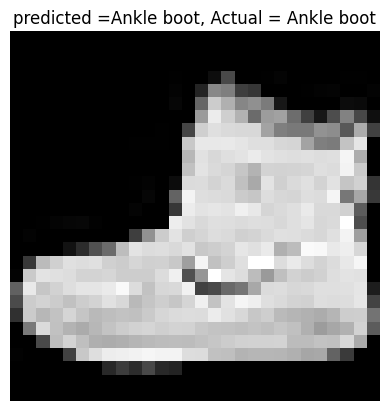

In [56]:
print(predictedOut[0],y_train[0])
index = np.argmax(predictedOut[0])
s = "predicted ="+ classes[index]+ ", Actual = "+classes[y_train[0]]
plt.imshow(x_train[0],cmap ='gray')
plt.axis("off")
plt.title(s)
plt.show()

In [34]:
print(len(weights),len(biases),len(preActivations),len(activations))

5 5 5 4


In [44]:
weights[0].shape

(200, 784)

In [41]:
preActivations[0].shape

(200, 1)

In [52]:
a = biases[0] + np.dot(weights[0],inputData[0].reshape(-1,1))
print(a.shape, inputData[0].shape)

(200, 1) (784,)


In [46]:
type(a)

numpy.ndarray

In [51]:
b = inputData[0]
b = b.reshape(-1,1)
b.shape

(784, 1)